In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Tạo dữ liệu ảnh từ các tọa độ trong file XML ( Đã có dữ liệu ảnh không cần chạy)

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
from lxml import etree
gannhan_dict={
    'AI':[1,2,3,4,7],
    'sensei':[23,25,26]
}
gannhan=['AI','sensei']
list_label=['car','motor','pedestrian','van','bus','truck','bicycle','tricycle']
def change(x):
  if x<0:
    return 0
  else:
    return x
    
def xml_to_csv(path,xml_list,i,j,label_list):
    for xml_file in glob.glob(path + '/*.xml'): #Tìm kiếm file xml
        parser = etree.XMLParser(recover=True) 
        tree = ET.parse(xml_file,parser=parser) #Chuyển xml sang sơ đồ cây 

        root = tree.getroot() #Lấy node của các cây 
        img_path=xml_file.replace('GanNhan','images').replace('xml','jpg') #Trỏ tới file ảnh 
        image=cv2.imread(img_path) #Đọc ảnh 
        if root is not None: #Nút không tồn tại thì ko đọc 
          for member in root.findall('object'): #Tìm các đối tượng các xe 
              bbx = member.find('bndbox') #Tìm khung 
              if bbx is not None: 
                xmin,ymin,xmax, ymax,label = change(int(bbx.find('xmin').text)),change(int(bbx.find('ymin').text)),change(int(bbx.find('xmax').text)),change(int(bbx.find('ymax').text)),member.find('name').text #Chuyển các vị trí tọa độ thành biến 

                if xmin<xmax and ymin<ymax and type(label)==str and label in list_label: #Tránh biến âm và các điều kiện không hợp lệ 
                  dim=(128,128)
                  if j=='AI' and (label=='car' or label=='motor'): #Tránh trường hợp chỉ quá nhiều xe car và motor 
                    continue
                  if type(image) != type(None):#Nếu đọc ảnh k dc 
                    x, y, w, h =  xmin,ymin,xmax, ymax
                    crop_img=cv2.resize(image[y:h, x:w],dim, interpolation = cv2.INTER_AREA) #Cắt ảnh theo tọa độ và resize ảnh theo ý mún 
                    xml_list.append(crop_img) #Thêm đối tượng 
                    label_list.append(label) #Thêm labels 
    return xml_list,label_list

xml_list,label_list = [],[] # Tạo list chứa các đối tượng và label 
for j in gannhan: # có 2 mục AI và sensei 
  for i in gannhan_dict[j]: #chạy vào mục của AI và sensei 
    os.chdir('/content/drive/MyDrive/Machine Learning/GanNhan/{}/{}'.format(j,i)) #Trỏ vị trí vào địa chỉ cần tới 
    image_path = os.path.join(os.getcwd()) #Địa chỉ từng file xml trong 1 mục 

    xml_list,label_list=xml_to_csv(image_path,xml_list,i,j,label_list) #Append thêm dữ liệu 

os.chdir('/content/drive/MyDrive/Machine Learning/data')#Trỏ tới thư mục cần lưu 
xml_list=np.array(xml_list) #Chuyển sang numpy 
data_raw = pd.DataFrame(xml_list.reshape(xml_list.shape[0],3072)) #chuyển sang DataFrame để lưu csv 
Y=pd.DataFrame(label_list) 
data_raw.to_csv('images.csv', index=None) 
Y.to_csv('labels.csv', index=None)
print('Successfully converted xml to csv.')



---
#**Chạy từ đây (Khi dữ liệu không còn vấn đề)**

#2. Chuyển từ CSV sang ảnh

In [ ]:

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Machine Learning/data/images.csv')
Y=pd.read_csv('/content/drive/MyDrive/Machine Learning/data/labels.csv')

#3.Predict Vật thể


---







In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(data,Y, test_size=0.2)


##3.1 SVC

In [ ]:
from sklearn.svm import SVC
classifier=SVC(kernel="rbf")
classifier.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

###3.1.2 The cofusion Matrix

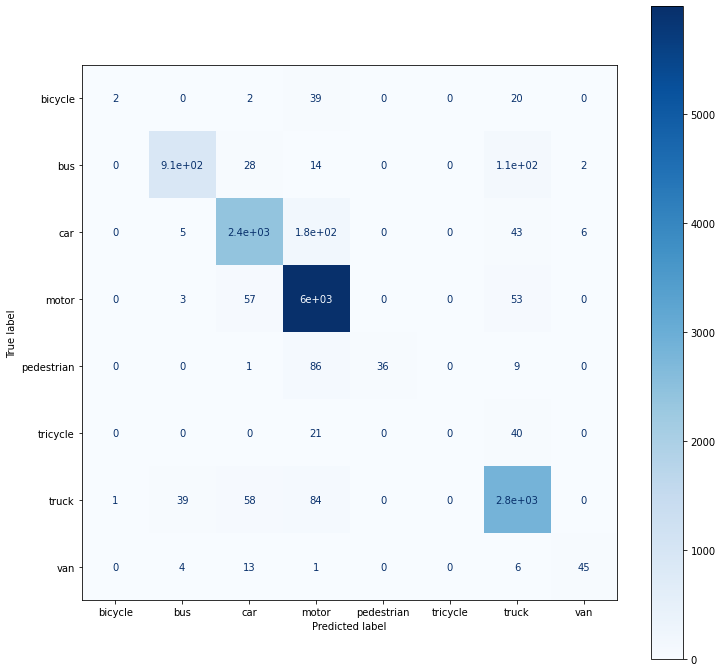

In [ ]:
# chạy confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

### 3.1.3 Score và đánh giá

In [ ]:
from sklearn.metrics import classification_report
list_label=['car','motor','pedestrian','van','bus','truck','bicycle','tricycle']
Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred, target_names=list_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         car       0.67      0.03      0.06        63
       motor       0.95      0.85      0.90      1064
  pedestrian       0.94      0.91      0.93      2641
         van       0.93      0.98      0.96      6103
         bus       1.00      0.27      0.43       132
       truck       0.00      0.00      0.00        61
     bicycle       0.91      0.94      0.92      3030
    tricycle       0.85      0.65      0.74        69

    accuracy                           0.93     13163
   macro avg       0.78      0.58      0.62     13163
weighted avg       0.93      0.93      0.92     13163



##3.2 NAIVE BAYES

In [ ]:
from sklearn.naive_bayes import GaussianNB
#classifier =OneVsRestClassifier(GaussianNB())
classifier = GaussianNB()
classifier.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

###3.2.2 The cofusion Matrix

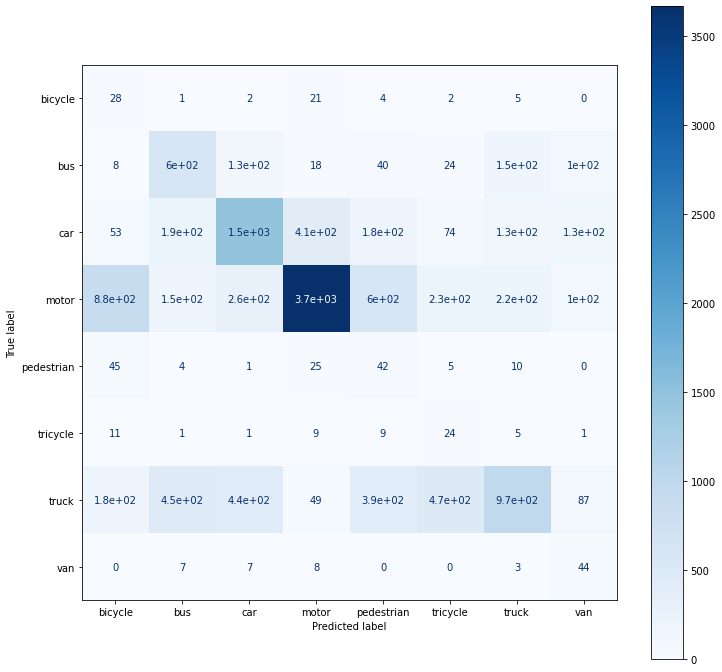

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

###3.2.3 Score và đánh giá 

In [ ]:
from sklearn.metrics import classification_report
Y_pred=classifier.predict(X_test)
list_label=['car','motor','pedestrian','van','bus','truck','bicycle','tricycle']
print(classification_report(y_test, Y_pred, target_names=list_label))

              precision    recall  f1-score   support

         car       0.02      0.44      0.04        63
       motor       0.43      0.56      0.48      1064
  pedestrian       0.64      0.56      0.60      2641
         van       0.87      0.60      0.71      6103
         bus       0.03      0.32      0.06       132
       truck       0.03      0.39      0.05        61
     bicycle       0.65      0.32      0.43      3030
    tricycle       0.09      0.64      0.16        69

    accuracy                           0.52     13163
   macro avg       0.35      0.48      0.32     13163
weighted avg       0.72      0.52      0.59     13163



##3.3 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(metric='cosine')
classifier.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

###3.3.2 The cofusion Matrix

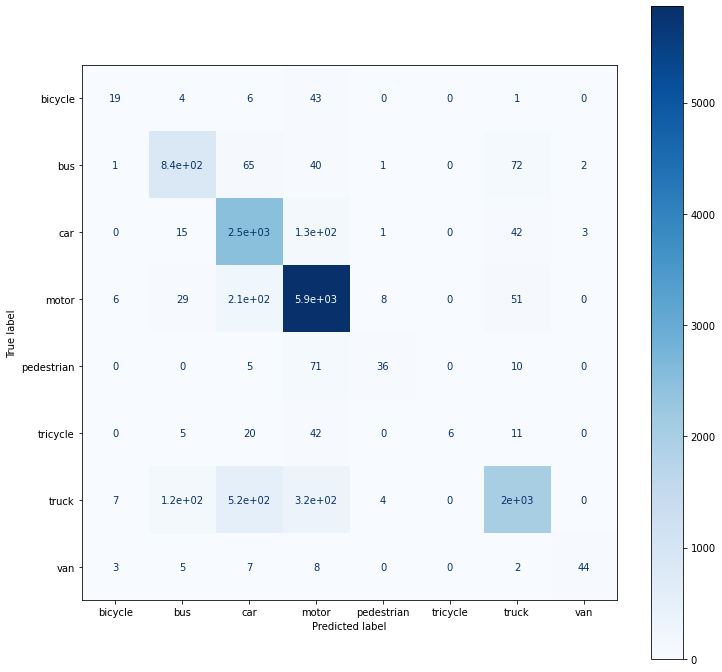

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

###3.3.3 Score và đánh giá 

In [ ]:
from sklearn.metrics import classification_report
Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

     bicycle       0.48      0.17      0.26        80
         bus       0.83      0.81      0.82      1054
         car       0.74      0.92      0.82      2580
       motor       0.90      0.95      0.92      6180
  pedestrian       0.75      0.27      0.40       123
    tricycle       0.69      0.17      0.27        54
       truck       0.92      0.68      0.78      3012
         van       0.86      0.69      0.76        80

    accuracy                           0.85     13163
   macro avg       0.77      0.58      0.63     13163
weighted avg       0.86      0.85      0.85     13163



##3.4 DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = "entropy")
classifier.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

###3.4.2 The confusion Matrix

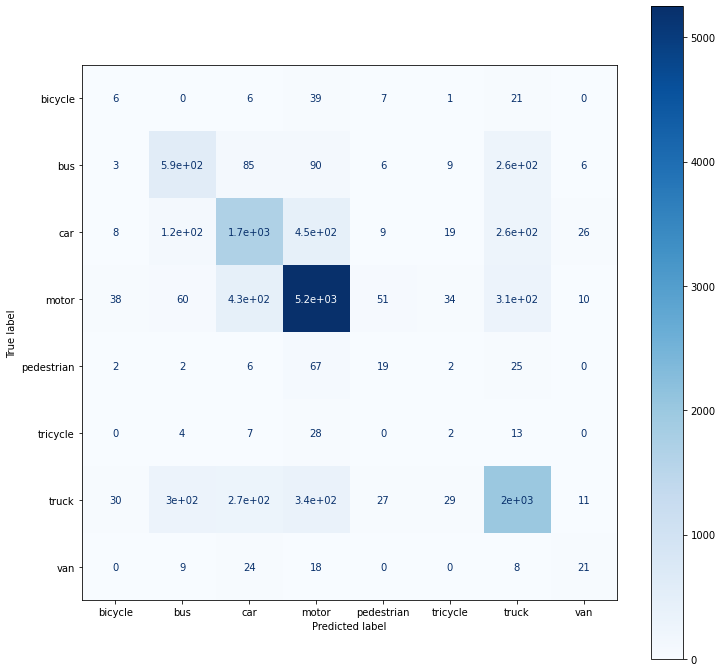

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

###3.4.3 Score và đánh giá 

In [ ]:
from sklearn.metrics import classification_report

Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

     bicycle       0.07      0.07      0.07        80
         bus       0.54      0.56      0.55      1054
         car       0.67      0.65      0.66      2580
       motor       0.84      0.85      0.84      6180
  pedestrian       0.16      0.15      0.16       123
    tricycle       0.02      0.04      0.03        54
       truck       0.69      0.66      0.68      3012
         van       0.28      0.26      0.27        80

    accuracy                           0.73     13163
   macro avg       0.41      0.41      0.41     13163
weighted avg       0.73      0.73      0.73     13163



##3.5 RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
classifier.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

###3.5.2 The confusion matrix

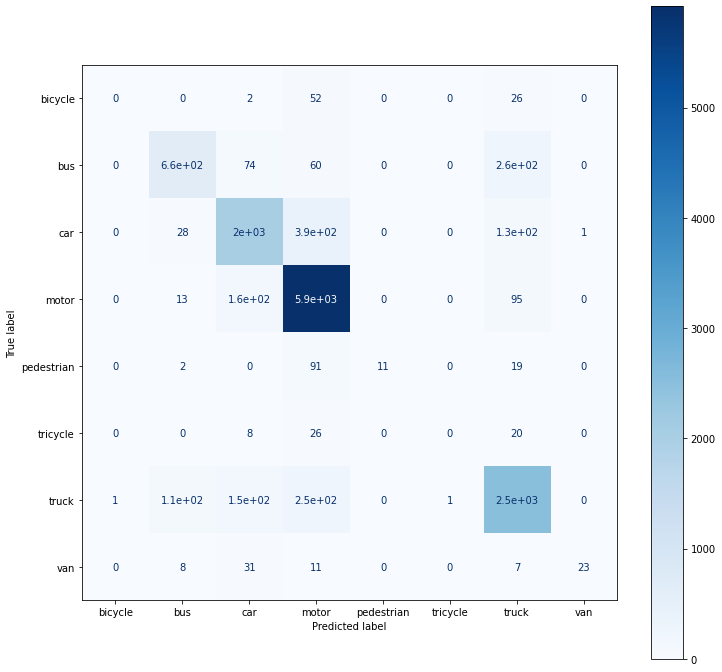

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

###3.5.3 Score và đánh giá

In [ ]:
from sklearn.metrics import classification_report
list_label=['car','motor','pedestrian','van','bus','truck','bicycle','tricycle']
Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred, target_names=list_label))

              precision    recall  f1-score   support

         car       0.00      0.00      0.00        80
       motor       0.80      0.62      0.70      1054
  pedestrian       0.83      0.78      0.81      2580
         van       0.87      0.96      0.91      6180
         bus       1.00      0.09      0.16       123
       truck       0.00      0.00      0.00        54
     bicycle       0.82      0.83      0.82      3012
    tricycle       0.96      0.29      0.44        80

    accuracy                           0.85     13163
   macro avg       0.66      0.45      0.48     13163
weighted avg       0.84      0.85      0.83     13163



##3.6 LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 5)
classifier.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###3.6.2 The confusion Matrix

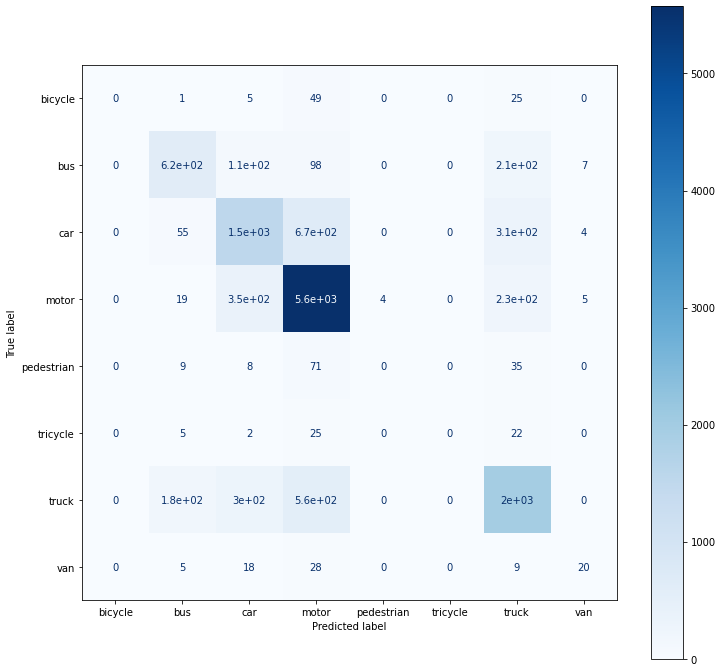

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

###3.6.3 Score và đánh giá

In [ ]:
from sklearn.metrics import classification_report
list_label=['car','motor','pedestrian','van','bus','truck','bicycle','tricycle']
Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred, target_names=list_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         car       0.00      0.00      0.00        80
       motor       0.69      0.59      0.64      1054
  pedestrian       0.66      0.60      0.63      2580
         van       0.79      0.90      0.84      6180
         bus       0.00      0.00      0.00       123
       truck       0.00      0.00      0.00        54
     bicycle       0.70      0.66      0.68      3012
    tricycle       0.56      0.25      0.34        80

    accuracy                           0.74     13163
   macro avg       0.42      0.37      0.39     13163
weighted avg       0.72      0.74      0.73     13163

